In [26]:
%matplotlib inline

In [27]:
import redqueen.opt_model as OM
import redqueen.opt_runs as OR
import redqueen.utils as RU
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import decorated_options as Deco
import multiprocessing as MP

In [28]:
sns.set_style(style='dark')
sns.set_palette('Set2')

In [29]:
from importlib import reload
reload(OM)
reload(OR)
reload(RU)

<module 'redqueen.utils' from '/home/utkarshu/miniconda3/lib/python3.6/site-packages/redqueen/utils.py'>

In [30]:
OR.SimOpts(**{
        'src_id': 1,
        'q_vec': [],
        's': 1.0,
        'other_sources': [
            (
                'Poisson', 
                {
                    'src_id': 2,
                    'seed': 42,
                    'rates': 100
                }
            )
        ],
        'sink_ids': [1001],
        'end_time': 100.0,
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [31]:
simOpts = OR.SimOpts.std_poisson(42, 1000)

# Exponential sampler

The output intensity is given by:

$$
u(t) = \exp( \underbrace{W_h \cdot h_j}_{\text{past}} - \overbrace{W_t (t - t_j)}^{\text{decay}} + \underbrace{b_t}_{\text{base}} )
$$

where $t_j$ is the last event before $t$.

It is simplified to the following in the code:

$$
u(t) = c \cdot e^{- W_t \cdot (t - t_j)}
$$

In [32]:
class ExpCDFSampler:
    """This is an exponential sampler."""
    
    @Deco.optioned()
    def __init__(self, Wh, Wt, bt, init_h, t_min, seed=42):
        self.seed = seed
        self.Wh = np.asarray(Wh)
        self.Wt = np.asarray(Wt)
        self.bt = np.asarray(bt)
        
        self.w = np.asarray(Wt)
        self.random_state = np.random.RandomState(seed)        
        self.reset(t_min, init_h, reset_sample=True)
        
    
    def reset_only_sample(self, cur_time):
        """Resets only the present sample. 
        This does not change the c, but only the t0 and generates another sample."""
        
        self.c = self.c * np.exp(-self.w * (cur_time - self.t0))
        self.t0 = cur_time
        self.u_unif = self.random_state.rand()
        
        return self.generate_sample()
    
    def cdf(self, t):
        """Calculates the CDF assuming that the last event was at self.t0"""
        return 1 - np.exp(- (self.c / self.w) * (1 - np.exp(- self.w * (t - self.t0))))
        
        
    def reset(self, cur_time, init_h, reset_sample):
        """Reset the sampler for generating another event."""

        if reset_sample:
            self.u_unif = self.random_state.rand()
        else:
            self.u_unif -= self.cdf(cur_time)
            
        self.h = init_h
        self.c = np.exp(self.Wh.dot(self.h) + self.bt)        
        self.t0 = cur_time
        
        return self.generate_sample()
            
        
    def register_event(self, time, new_h, own_event):
        """Saves the event and generated a new time for the next event."""
        self.reset(time, new_h, reset_sample=own_event)            
        return self.generate_sample()
    
    
    def get_last_hidden_state(self):
        return self.h
    
        
    def generate_sample(self):
        """Find a sample from the Exp process."""
        # Have the uniform sample already drawn
        D = 1 + (self.w / self.c) * np.log(1 - self.u_unif)
        if D <= 0.0:
            # This is the probability that no event ever happens
            return np.inf
        else:
            return self.t0 - (1 / self.w) * np.log(D)
    

Testing the sampler.

In [34]:
def_plot_opts = Deco.Options(Wh=0.5, 
                             Wt=1.0,
                             bt=1.0,
                             init_h=0,
                             t_min=0,
                             t_max=10,
                             resolution=200)

@Deco.optioned()
def plot_lambda(Wh, Wt, bt, init_h, t_min, t_max, events, resolution):
    X = np.linspace(t_min, t_max, num=resolution)
    
    
    event_idx = 0
    c = np.exp(Wh * init_h + bt)
    t0 = t_min
    
    # TODO: In the baseilne, shouldn't the t_0 still be updated to the latest event?
    Y1 = [c * np.exp(-Wt * (x - t0)) for x in X]
    
    Y2 = [None] * len(X)
    for idx, x in enumerate(X):
        while event_idx < len(events) and events[event_idx][0] < x:
            c = np.exp(Wh * events[event_idx][1] + bt)
            t0 = events[event_idx][0]
            event_idx += 1
            
        Y2[idx] = c * np.exp(-Wt * (x - t0))
    
    plt.step(X, Y1, '--', label='Baseline')
    plt.step(X, Y2, '-', label='Correct')
    plt.vlines([x[0] for x in events], ymin=0, ymax=max(Y2), label='Events')
    plt.legend()
    return (X, Y1, Y2)

In [35]:
events = [(1, -8), (5, 5), (9, 0)]

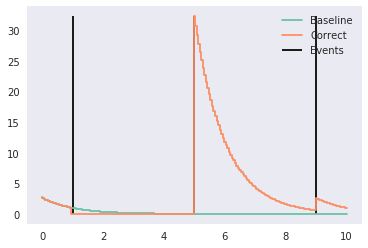

In [36]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [12]:
sampler = ExpCDFSampler(_opts=def_plot_opts, seed=101 + 1279)

In [13]:
sampler.generate_sample()

0.6092880541958573

In [14]:
sampler.reset_only_sample(sampler.generate_sample())

0.98369540000156641

In [15]:
sampler.reset(1, -4, False)

0.9725887021550208

In [16]:
sampler.register_event(5, 0.5, False)

4.924794439657469

In [17]:
sampler.reset_only_sample(sampler.generate_sample())

4.9482122321618336

In [18]:
sampler.register_event(9, 0, False)

8.7893001591946209

In [19]:
sampler.reset_only_sample(sampler.generate_sample())

9.0386156318159898

In [20]:
sampler.generate_sample()

9.0386156318159898

## Tests

In [37]:
%%time
all_sim_events = []
processes = None
N = 10000
verbose = False

assert not verbose or (N < 10 and processes is not None), "Cannot have verbose output with these settings."

def worker_sampler(params):
    ii, sampler = params
    event_idx = 0
    next_sample = sampler.generate_sample()
    sim_events = []
        
    while next_sample < def_plot_opts.t_max or event_idx < len(events):
        while event_idx < len(events) and \
              events[event_idx][0] < next_sample:
            # print("Old = ", next_sample)
            old_sample = next_sample
            next_sample = sampler.register_event(events[event_idx][0], 
                                                 events[event_idx][1], 
                                                 False)
            if verbose:
                print("Eps = {}, Old = {}, Event = {}, Next = {}"
                      .format(ii, old_sample, events[event_idx], next_sample))
                
            event_idx += 1
            
        if next_sample > def_plot_opts.t_max:
            break
            
        if verbose:
            print("Final sample = {}".format(next_sample))                
        
        sim_events.append(next_sample)
        next_sample = sampler.reset_only_sample(next_sample)
    
    return sim_events
    

with MP.Pool(processes=processes) as pool:
    for sim_events in pool.map(worker_sampler,
                               [(ii, ExpCDFSampler(_opts=def_plot_opts, seed=101 + ii))
                                for ii in range(N)]):
        all_sim_events.append(sim_events)


CPU times: user 1.37 s, sys: 507 ms, total: 1.88 s
Wall time: 2.12 s


In [38]:
flat_events = [x for y in all_sim_events for x in y]

In [39]:
[x for x in flat_events if x < 0]

[]

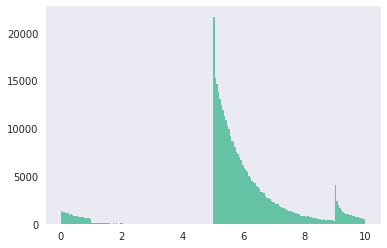

In [40]:
plt.hist(flat_events, bins=200);

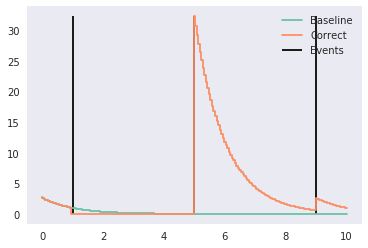

In [41]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [43]:
len(all_sim_events)

10

# Reinf broadcaster

In [28]:
iterSession = tf.InteractiveSession()

In [30]:
iterSession.run(tf.one_hot([0,1], depth=1, dtype=tf.float32))

array([[ 1.],
       [ 0.]], dtype=float32)

In [ ]:
input_dim = 1
hidden_dim = 16

class ReinfNetwork():
    def __init__(self, s_size, scope, trainer):
        with tf.variable_scope(scope):
            self.event_source = tf.placeholder(dtype=tf.int64, name='Event source', shape=[1])
            self.inp = tf.one_hot(indices=[self.event_source], depth=1, dtype=tf.float32)
            self.cell = tf.contrib.rnn.BasicRNNCell(hidden_dim)
            self.Wh = tf.get_variable('Wh', shape=)
            
            
            

In [25]:
class Reinf(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, hidden_dim):
        super(Reinf, self).__init__(src_id, seed)
        self.init = False
        
        self.
        self.Wh = tf.get_variable()
        
    def get_next_interval(self, event):
        if not self.init:
            # Create variables here?
            self.init = True
        
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return np.inf
        
        elif event.src_id == self.src_id:
            # We posted. Calculate reward.
            # We would never like to post now.
            return np.inf
        
        else:
            # Update our rate of posting.
            r_t = self.state.get_wall_rank(self.src_id, self.sink_ids,
                                           dict_form=False)
            # TODO: Magic.
            #  1 - Reward for this interval?
            #  2 - Sample the posting time again using inverse CDF
            #  3 - New sample is guaranteed to be closer to now than
            #      the original posting time.
            cur_time = event.cur_time
            t_delta_new = 10 # TODO: Take a new sample here.
            return cur_time + t_delta_new - self.last_self_event_time
        
    def train(self):
        """Will do RL here."""
        pass
            


In [26]:
mgr = simOpts.create_manager_with_broadcaster(Reinf(1, 100))

In [27]:
mgr.run_dynamic()

In [28]:
df = mgr.state.get_dataframe()

In [29]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1001,2,0.004632,0.004632
1,101,1001,2,0.005062,0.000430
2,102,1001,2,0.005522,0.000461
3,103,1001,2,0.006952,0.001430
4,104,1001,2,0.009197,0.002245
